# Machine Learning Price Prediction Trading Strategy

In [108]:
# Import libraries
import math  
import pandas_datareader as web  
import yfinance as yf  
import datetime  
import numpy as np  
import pandas as pd 
import scipy.stats as stats 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler  
from keras.models import Sequential  
from keras.layers import Dense, LSTM  
from sklearn.model_selection import TimeSeriesSplit

In [109]:
# Define the date range for data retrieval
start_date = datetime.datetime(2013, 1, 1)
end_date = datetime.datetime(2023, 1, 1)

# Fetch S&P 500 data using Yahoo Finance
sp500 = yf.Ticker('^GSPC')
sp500_data = sp500.history(period="1d", start=start_date, end=end_date)

# Remove the time zone information from the date index
sp500_data.index = sp500_data.index.date

# Remove the specified columns and reorder the remaining ones
df = sp500_data[['High', 'Low', 'Open', 'Close', 'Volume']]  

# Display the DataFrame
df 

High          Low         Open        Close      Volume
2013-01-02  1462.430054  1426.189941  1426.189941  1462.420044  4202600000
2013-01-03  1465.469971  1455.530029  1462.420044  1459.369995  3829730000
2013-01-04  1467.939941  1458.989990  1459.369995  1466.469971  3424290000
2013-01-07  1466.469971  1456.619995  1466.469971  1461.890015  3304970000
2013-01-08  1461.890015  1451.640015  1461.890015  1457.150024  3601600000
...                 ...          ...          ...          ...         ...
2022-12-23  3845.800049  3797.010010  3815.110107  3844.820068  2819280000
2022-12-27  3846.649902  3813.219971  3843.340088  3829.250000  3030300000
2022-12-28  3848.320068  3780.780029  3829.560059  3783.219971  3083520000
2022-12-29  3858.189941  3805.449951  3805.449951  3849.280029  3003680000
2022-12-30  3839.850098  3800.340088  3829.060059  3839.500000  2979870000

[2518 rows x 5 columns]

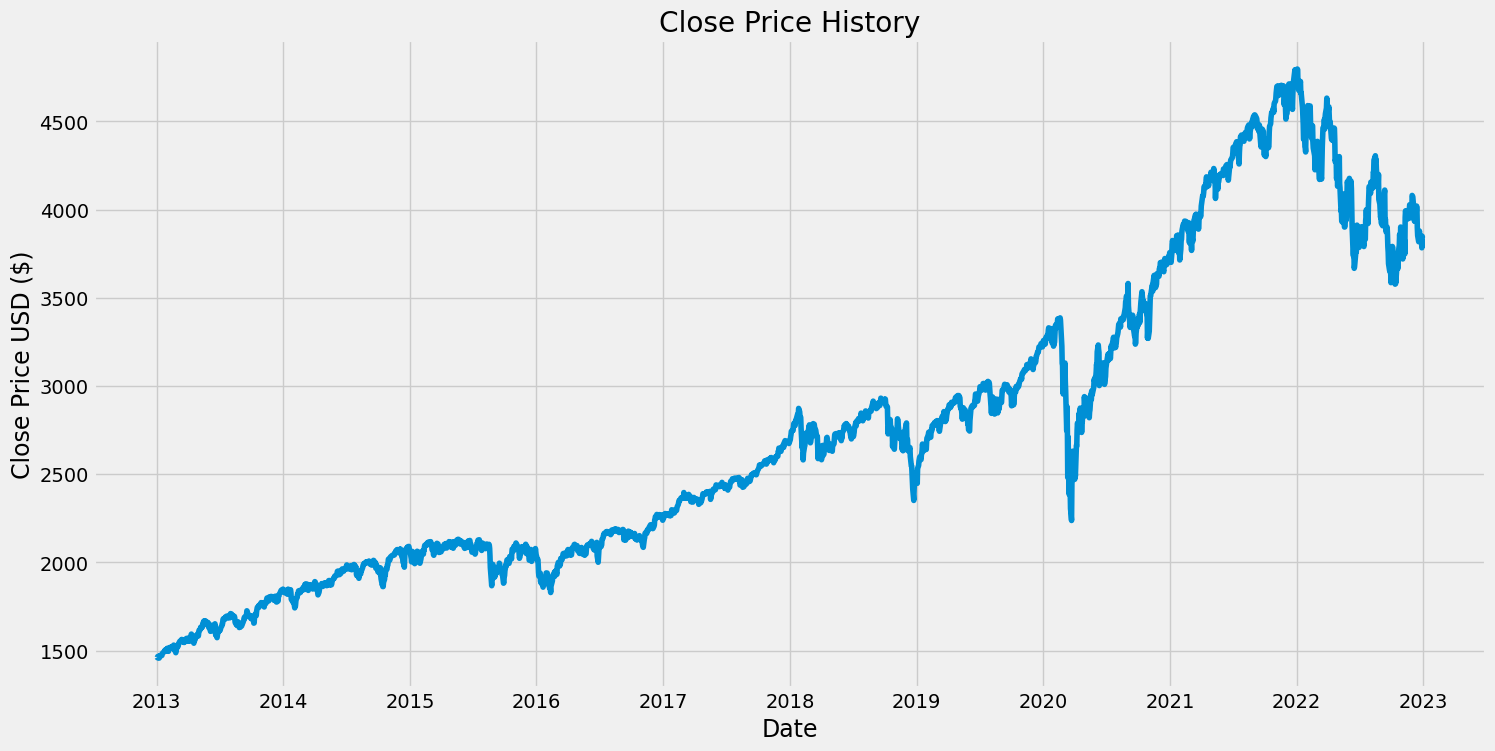

In [110]:
# Styling the plots
plt.style.use('fivethirtyeight')

# Create a figure for the plot 
plt.figure(figsize=(16, 8))

# Set the title for the plot
plt.title('Close Price History')

# Plot the closing prices over time
plt.plot(df['Close'])

# Label the x-axis and y-axis
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Display the plot
plt.show()

## Build and train the LSTM model

In [111]:
# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Determine the number of rows for training the model (80% of the data)
training_data_len = math.ceil(len(dataset) * 0.8)

# Print the calculated training data length
print(training_data_len)

# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Print the scaled data
print(scaled_data)

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Initialize empty lists for training data and labels
x_train = []  # Input sequences
y_train = []  # Corresponding output values

# Iterate through the data to create training sequences
for i in range(60, len(train_data)):
    # Create input sequence with the previous 60 data points
    x_train.append(train_data[i-60:i, 0])
    
    # Create the corresponding output value
    y_train.append(train_data[i, 0])

    # Print the input sequences and labels for the first iteration
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

2015
[[1.57812891e-03]
 [6.64779311e-04]
 [2.79089605e-03]
 ...
 [6.96551164e-01]
 [7.16333119e-01]
 [7.13404449e-01]]
[array([0.00157813, 0.00066478, 0.0027909 , 0.00141941, 0.        ,
       0.00115889, 0.00448282, 0.00446187, 0.00405162, 0.00454869,
       0.00463554, 0.00712399, 0.00863325, 0.01060368, 0.01127745,
       0.01128041, 0.01371797, 0.01288552, 0.01517931, 0.01341852,
       0.01226563, 0.01677542, 0.01154693, 0.01621245, 0.01646098,
       0.01564348, 0.01820083, 0.01792532, 0.01865001, 0.01891949,
       0.01923393, 0.01875781, 0.02209669, 0.01641006, 0.01355629,
       0.01750308, 0.00919323, 0.01191525, 0.01761987, 0.0172276 ,
       0.01828165, 0.02037783, 0.02474689, 0.02524696, 0.02608544,
       0.02815768, 0.0296669 , 0.02854695, 0.02915784, 0.03176608,
       0.03100845, 0.02843315, 0.0273072 , 0.03041254, 0.02654661,
       0.02986755, 0.02831037, 0.03192779, 0.03165228, 0.03355081])]
[0.0314486746031018]



In [112]:
# Convert the x_train and y_train lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the training data to match the input requirements of an LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Print the shape of the reshaped training data
x_train.shape

(1955, 60, 1)

In [113]:
# Create an LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units and return sequences
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add the second LSTM layer with 50 units and do not return sequences
model.add(LSTM(50, return_sequences=False))

# Add a dense layer with 25 units
model.add(Dense(25))

# Add the output layer with a single unit for regression
model.add(Dense(1))

In [114]:
# Compile the LSTM model (Adaptive Moment Estimation)
model.compile(optimizer='adam', loss='mean_squared_error')

In [115]:
# Train the LSTM model with the training data
model.fit(x_train, y_train, batch_size=1, epochs=1)

1955/1955 [==============================] - 15s 7ms/step - loss: 9.4930e-04


## Test the LSTM model and make predictions

In [116]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Initialize empty lists for testing data and labels
x_test = []  # Input sequences
y_test = dataset[training_data_len:, :]  # Corresponding output values

# Iterate through the test data to create testing sequences
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [117]:
# Convert the testing input data to a NumPy array
x_test = np.array(x_test)

# Reshape the testing input data to match the input requirements of the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values for the test data
predictions = model.predict(x_test)

# Inverse transform the scaled predictions to their original scale
predictions = scaler.inverse_transform(predictions)

16/16 [==============================] - 0s 5ms/step


In [118]:
# Calculate the Root Mean Squared Error (RMSE) to evaluate the model's performance
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

84.47646752100475

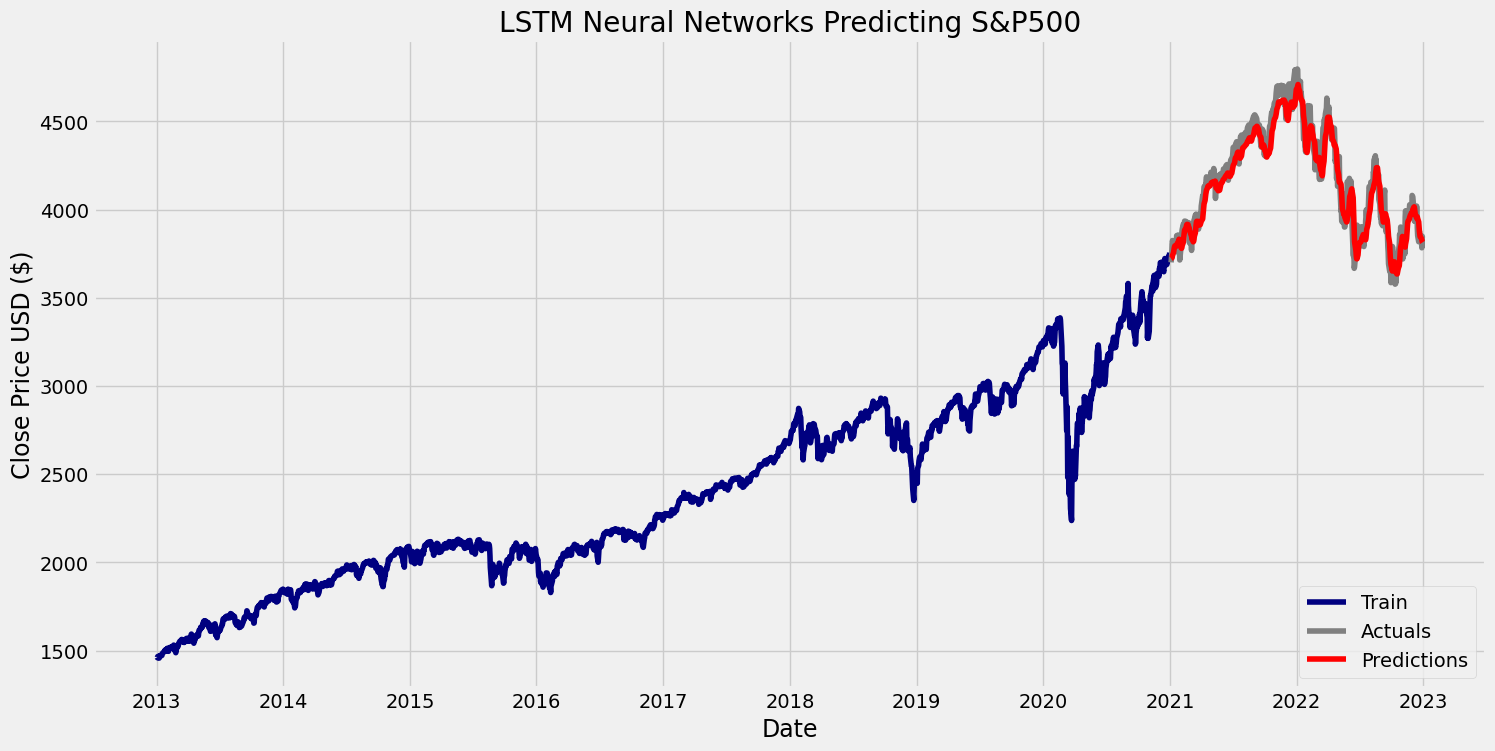

In [119]:
# Separate the data into training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()  # Create a copy to avoid the SettingWithCopyWarning
valid['Predictions'] = predictions  # Add predicted values to the 'valid' DataFrame

# Create a plot to visualize the data
plt.figure(figsize=(16, 8))
plt.title('LSTM Neural Networks Predicting S&P500')
plt.xlabel('Date', fontsize=17)
plt.ylabel('Close Price USD ($)', fontsize=17)

# Plot the 'Close' prices from the training data
plt.plot(train['Close'], label='Train', color='navy')

# Plot the 'Close' prices from the validation data
plt.plot(valid['Close'], label='Actuals', color='grey')

# Plot the 'Predictions' from the validation data
plt.plot(valid['Predictions'], label='Predictions', color='red')

# Add a legend to the plot
plt.legend(loc='lower right')

# Display the plot
plt.show()

In [120]:
# Display the DataFrame containing actual and predicted prices
valid

Close  Predictions
2021-01-04  3700.649902  3721.693115
2021-01-05  3726.860107  3723.048584
2021-01-06  3748.139893  3724.301758
2021-01-07  3803.790039  3727.851562
2021-01-08  3824.679932  3739.191895
...                 ...          ...
2022-12-23  3844.820068  3846.269287
2022-12-27  3829.250000  3836.236328
2022-12-28  3783.219971  3828.241455
2022-12-29  3849.280029  3816.625244
2022-12-30  3839.500000  3813.653564

[503 rows x 2 columns]

## Time series split validation

In [130]:
# Define the number of splits
n_splits = 5  # You can adjust this number as needed

# Create a new DataFrame with only the 'Close' column
data = df.filter(['Close'])

# Convert the DataFrame to a NumPy array
dataset = data.values

# Create a Min-Max scaler object with a specified feature range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the dataset and store it in a new variable
scaled_data = scaler.fit_transform(dataset)

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Lists to store RMSE values for each fold
rmse_values = []

# Define your LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(60, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Iterate through the time series splits
for train_index, test_index in tscv.split(scaled_data):
    # Split the data into training and testing sets for this fold
    train_data, test_data = scaled_data[train_index], scaled_data[test_index]

    # Create the training data set
    x_train, y_train = [], []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i - 60:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the testing data set
    x_test, y_test = [], []

    for i in range(60, len(test_data)):
        x_test.append(test_data[i - 60:i, 0])

    x_test, y_test = np.array(x_test), test_data[60:, 0]

    # Get the model's predicted price values for the test data
    predictions = model.predict(x_test)

    # Inverse transform the scaled predictions to their original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the Root Mean Squared Error (RMSE) for this fold
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    rmse_values.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = np.mean(rmse_values)
print("Average RMSE:", average_rmse)

12/12 [==============================] - 0s 5ms/step
Average RMSE: 1445.896346893177


## Comparing the actual stock price with the predictions

In [122]:
# Assuming your DataFrame is already loaded as 'valid'
# You can calculate the cumulative percentage gain using the following code:

# Calculate the daily percentage change in the actual close prices
valid['Actual_Pct_Change'] = valid['Close'].pct_change() * 100

# Create a new column 'Buy_Sell' based on your prediction strategy
valid['Buy_Sell'] = valid['Predictions'].shift(-1) > valid['Close']

# Calculate the daily percentage gain based on your strategy
valid['Strategy_Pct_Change'] = valid['Buy_Sell'].shift(1) * valid['Actual_Pct_Change']

# Calculate the cumulative percentage gain for your strategy
valid['Cumulative_Strategy_Gain'] = (1 + valid['Strategy_Pct_Change'] / 100).cumprod() - 1

# Calculate the cumulative percentage gain if you kept the stock during the entire period
valid['Cumulative_Hold_Gain'] = (1 + valid['Actual_Pct_Change'] / 100).cumprod() - 1

# Print the last row of the DataFrame to get the final cumulative gains
final_cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].iloc[-1]
final_cumulative_hold_gain = valid['Cumulative_Hold_Gain'].iloc[-1]

print(f'Cumulative Percentage Gain with Strategy: {final_cumulative_strategy_gain:.2%}')
print(f'Cumulative Percentage Gain with Holding: {final_cumulative_hold_gain:.2%}')

Cumulative Percentage Gain with Strategy: 26.00%
Cumulative Percentage Gain with Holding: 3.75%


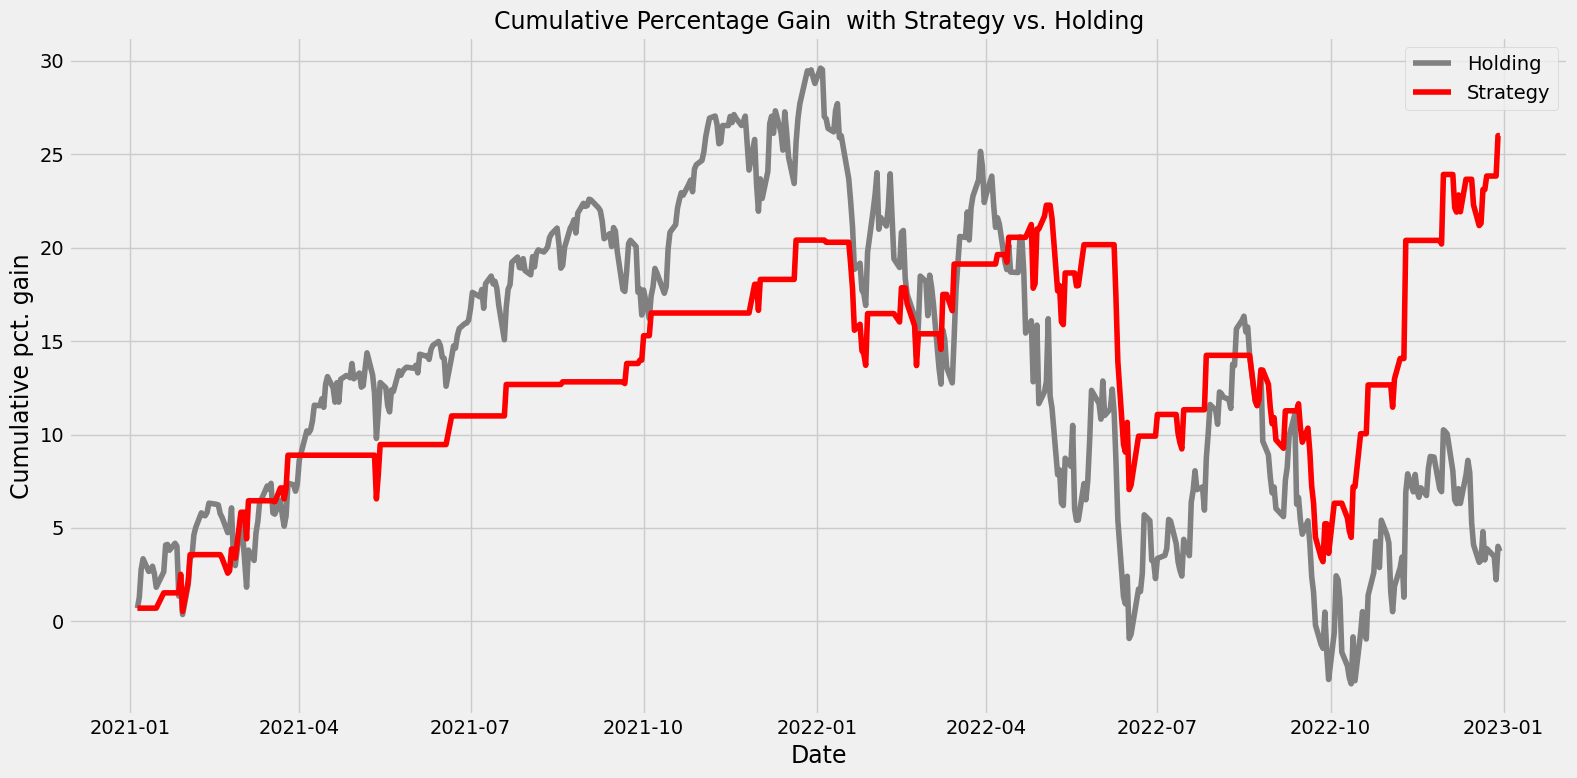

In [123]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the cumulative percentage gain for the actual stock price
ax.plot(valid.index, valid['Cumulative_Hold_Gain'] * 100, label='Holding', color='grey')

# Plot the cumulative percentage gain with predictions
ax.plot(valid.index, valid['Cumulative_Strategy_Gain'] * 100, label='Strategy', color='red')

# Set labels and title with a font size of 17
ax.set_xlabel('Date', fontsize=17)
ax.set_ylabel('Cumulative pct. gain', fontsize=17)
ax.set_title('Cumulative Percentage Gain  with Strategy vs. Holding', fontsize=17)

# Add a legend
ax.legend()

# Add a grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

## Testing for statistical significance

In [124]:
# Extract the cumulative gains for the hold strategy and the strategy with predictions
cumulative_hold_gain = valid['Cumulative_Hold_Gain'].dropna().values
cumulative_strategy_gain = valid['Cumulative_Strategy_Gain'].dropna().values

# Calculate the mean and standard deviation for both strategies
mean_hold = cumulative_hold_gain.mean() * 100  # Multiply by 100 to express as a percentage
std_hold = cumulative_hold_gain.std() * 100    # Multiply by 100 to express as a percentage
mean_strategy = cumulative_strategy_gain.mean() * 100  # Multiply by 100 to express as a percentage
std_strategy = cumulative_strategy_gain.std() * 100    # Multiply by 100 to express as a percentage

# Perform a two-sided t-test
t_stat, p_value = stats.ttest_rel(cumulative_hold_gain, cumulative_strategy_gain)

# Define the significance level (alpha)
alpha = 0.05

# Check if the p-value is less than alpha to determine significance
if p_value < alpha:
    print(f'The t-test is statistically significant (p = {p_value:.2e}).')
    print('There is a significant difference between the cumulative gains of the holding strategy and the trading strategy.')
else:
    print(f'The t-test is not statistically significant (p = {p_value:.2e}).')
    print('There is no significant difference between the cumulative gains of the holding strategy and the trading strategy.')

# Print the t-value, mean, and standard deviation for both strategies as percentages
print(f'T-Value: {t_stat:.4f}')
print(f'Mean Cumulative Gain (Holding): {mean_hold:.2f}%')
print(f'Standard Deviation (Holding): {std_hold:.2f}%')
print(f'Mean Cumulative Gain (Strategy): {mean_strategy:.2f}%')
print(f'Standard Deviation (Strategy): {std_strategy:.2f}%')

The t-test is not statistically significant (p = 5.75e-01).
There is no significant difference between the cumulative gains of the holding strategy and the trading strategy.
T-Value: -0.5610
Mean Cumulative Gain (Holding): 13.14%
Standard Deviation (Holding): 8.15%
Mean Cumulative Gain (Strategy): 13.32%
Standard Deviation (Strategy): 5.60%
